<a href="https://colab.research.google.com/github/mslarson94/NMA2022_ECoG/blob/main/Code/TA_nma_ecog_psd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Data retrieval
import os, requests

fname = 'memory_nback.npz'
url = "https://osf.io/xfc7e/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
import pandas as pd
import math
from scipy import signal

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# @title Install packages (`nilearn`, `nimare`, `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [6]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat_11 = alldat[1][1]

print(dat_11.keys())

dict_keys(['V', 't_off', 'locs', 'srate', 'scale_uv', 't_on', 'target', 'stim_id', 'response', 'rt', 'expinfo', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [ ]:
# Filter the data
# choose which subject and block you want to look at!! 
# example: dat_filt = alldat[0][3] is subject 0, block 3 (2-back)
dat_filt = alldat[0][3]
V_ = dat_filt['V'].astype('float32') # always convert the voltage data to float32!

# bandpass filter between 4 and 8 Hz
b, a = signal.butter(3, [4,8], btype='bandpass', fs=1000)
V_filt = signal.filtfilt(b, a, V_, 0)

# normalize each channel so its mean power is 1
V_filt = V_filt/V_filt.mean(0)



In [7]:

def get_voltage_patient_expirement_data(data, patient, experiment,freq_range):
    # compute spectral power above 50Hz and low-pass below 10Hz
  # power is always positive, so we normalize it by its average
  from scipy import signal
  dat=data[patient][experiment]
  V = dat['V'].astype('float32') # always convert the voltage data to float32!

  # # high-pass filter above 50 Hz
  # b, a = signal.butter(3, [freq_range[1]], btype='high', fs=1000)
  # V = signal.filtfilt(b, a, V, 0)

  # b, a = signal.butter(3, [freq_range[0]], btype='low', fs=1000)
  # V = signal.filtfilt(b, a, V, 0)

  # # compute smooth envelope of this signal = approx power
  # V = np.abs(V)**2
  # b, a = signal.butter(3, [freq_range[0]], btype='low', fs=1000)
  # V = signal.filtfilt(b, a, V, 0)

  # # normalize each channel so its mean power is 1
  # V = V/V.mean(0)

  # # high-pass filter above 50 Hz
  b, a = signal.butter(3, [freq_range[0],freq_range[1]], btype='bandpass', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  V/V.mean(0)
  return V, dat

In [10]:
for subj_n in [0,1]:
  for exp_n in [1,2,3]:
    store=[]
    other_store=[]
    BA_list=[6,7,8,9,10,32,40,45,46,47]
    BA_chan_list=[None] * len(BA_list)
    Lobe_chan_list=[None] *2*len(BA_list)
    k=0
    kk=0
    subject_number=subj_n
    experiment_number=exp_n
    f_range=[4,8]
    V, dat=get_voltage_patient_expirement_data(alldat,subject_number,experiment_number,f_range)
    for j in BA_list:
      print('Brodmann Area '+str(j))
      for i in range(63):
        if dat['Brodmann_Area'][i]=='Brodmann area '+str(j):
          store.append(i)
      BA_chan_list[k]=store
      for idx in ['Frontal Lobe', 'Parietal Lobe']:
        for jj in BA_chan_list[k]:
          if dat['lobe'][jj]==idx:
            other_store.append(jj)
        Lobe_chan_list[kk]=other_store
        other_store=[]
        kk+=1 

      store=[]
      other_store=[]
      k+=1

    Frontal=Lobe_chan_list[:len(BA_list)]
    Parietal=Lobe_chan_list[len(BA_list):]
    print('Frontal Lobe List is ',Frontal, 'for subject', subj_n,'experiment',exp_n)
    print('Parietal Lobe List is',Parietal, 'for subject', subj_n,'experiment',exp_n)

Brodmann Area 6
Brodmann Area 7
Brodmann Area 8
Brodmann Area 9
Brodmann Area 10
Brodmann Area 32
Brodmann Area 40
Brodmann Area 45
Brodmann Area 46
Brodmann Area 47
Frontal Lobe List is  [[3, 4, 5, 6, 12, 13, 14, 21, 22, 29, 37, 46, 54], [], [], [0, 8], [7, 15, 23, 30], [], [31, 38, 39], [], [], []] for subject 0 experiment 1
Parietal Lobe List is [[], [], [], [16, 17, 18, 24, 25, 26, 32, 33, 34, 41, 42, 43, 49, 50, 51, 52], [47], [], [], [], [], []] for subject 0 experiment 1
Brodmann Area 6
Brodmann Area 7
Brodmann Area 8
Brodmann Area 9
Brodmann Area 10
Brodmann Area 32
Brodmann Area 40
Brodmann Area 45
Brodmann Area 46
Brodmann Area 47
Frontal Lobe List is  [[3, 4, 5, 6, 12, 13, 14, 21, 22, 29, 37, 46, 54], [], [], [0, 8], [7, 15, 23, 30], [], [31, 38, 39], [], [], []] for subject 0 experiment 2
Parietal Lobe List is [[], [], [], [16, 17, 18, 24, 25, 26, 32, 33, 34, 41, 42, 43, 49, 50, 51, 52], [47], [], [], [], [], []] for subject 0 experiment 2
Brodmann Area 6
Brodmann Area 7
Br

In [ ]:
### FOR LOOKING AT ALL CHANNELS ###

# divide into trials and average
nt, nchan = V_filt.shape
nstim = len(dat_filt['t_on'])

# use a timerange from 400ms before to 1600ms after the stimulus onset
trange = np.arange(-900, 0)
ts = dat_filt['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V_filt[ts, :], (nstim, 900, nchan))

V_resp = (V_epochs[dat_filt['response'] == 1]).mean(0)
V_base = (V_epochs[dat_filt['response'] == 0]).mean(0)

In [ ]:
#chen made this function 
def Average(lst):
    return sum(lst) / len(lst)

In [14]:
list(set().union(lst1, lst2, lst3)

TypeError: ignored

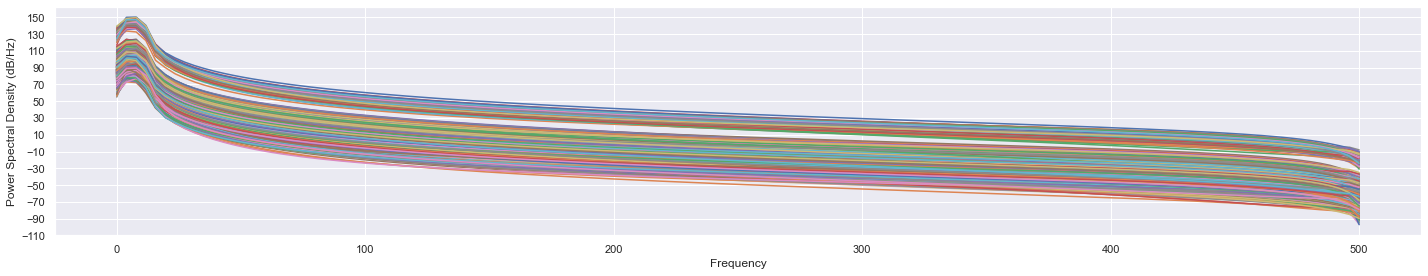

In [ ]:
# this is to create and plot all PSDs from each trial in each channel
# WARNING: this takes a long time to run

#initialize temp matrix to store the PSDs for each t_on
temp_ave_psd=np.zeros((60,100,129))
ave_chan=[None]*6
for k in len(ave_chan):
temp_ave_chan = np.zeros((60,100,129))
for i in range(60):
    psd0_list= np.zeros((100,129))
    freq0_list= np.zeros((100,129))
    for j in range(100):
        Pxx, freqs=plt.psd(V_epochs[j,:,i],Fs=1000)
        Pxx=10*np.log10(Pxx)
        temp_ave_chan[i][j] = Pxx  
        freq0_list[j] = freqs
        #temp_ave_chan is the final array with all the data

In [ ]:
# after you run the previous cell, you need to permanently store the data from temp_ave_chan
# comment out all but one of these in order to store the data based on which subject and block you filtered for

#ave_chan_01 = temp_ave_chan
#ave_chan_02 = temp_ave_chan
#ave_chan_03 = temp_ave_chan
#ave_chan_11 = temp_ave_chan
#ave_chan_12 = temp_ave_chan
#ave_chan_13 = temp_ave_chan


In [ ]:
# this is a sanity check to make sure all arrays are different

print(ave_chan_01[0][0][0])
print(ave_chan_02[0][0][0])
print(ave_chan_03[0][0][0])
print(ave_chan_11[0][0][0])
print(ave_chan_12[0][0][0])
print(ave_chan_13[0][0][0])

72.72078416095268
82.48951643475914
96.37796691416783
87.05786930204825
92.99164790014333
107.7776142263989


In [ ]:
#the histogram throws this warning, run this so you don't get the message every time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [ ]:
#this is to pull out just the average theta power

# 0-back
psd_lme_11 = np.zeros((100))
for a in range(100):
    psd_lme_11[a] = np.mean(ave_chan_11[0][a][1:3])
    
# 1-back
psd_lme_12 = np.zeros((100))
for b in range(100):
    psd_lme_12[b] = np.mean(ave_chan_12[0][b][1:3])

# 2-back
psd_lme_13 = np.zeros((100))
for c in range(100):
    psd_lme_13[c] = np.mean(ave_chan_13[0][c][1:3])

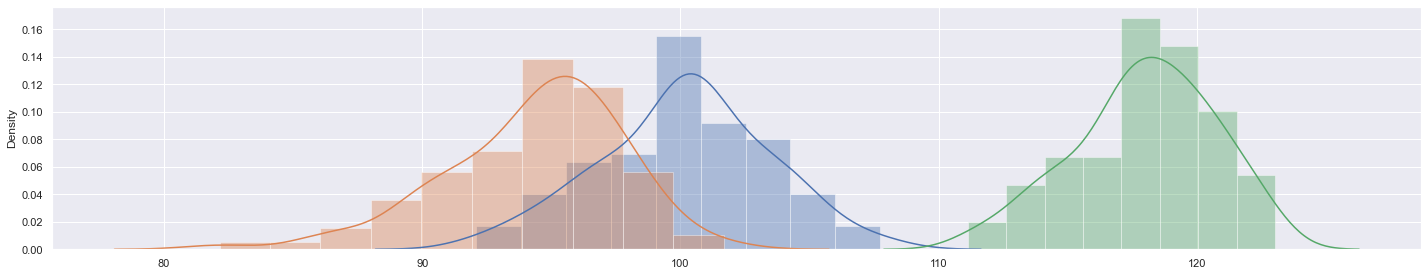

In [ ]:
plt.figure()
sns.distplot(psd_lme_11)
sns.distplot(psd_lme_12)
sns.distplot(psd_lme_13)
plt.show()

In [ ]:
## Now we wil create the data frame and run the LME

In [ ]:
# this gets all PSDs in one list
psd_lme_sub1 = np.concatenate((psd_lme_11, psd_lme_12, psd_lme_13), axis=None)
print(len(psd_lme_sub1))

300


In [ ]:
# create the list of block types for the data frame
block_11 = ['0-back']*100
block_12 = ['1-back']*100
block_13 = ['2-back']*100
df_task_block = np.concatenate((block_11, block_12, block_13), axis=None)

In [ ]:
# create the list of target and responses for the data frame
dat_11 = alldat[1][1]
dat_12 = alldat[1][2]
dat_13 = alldat[1][3]
df_target = np.concatenate((dat_11['target'], dat_12['target'], dat_13['target']),axis=None)
df_response = np.concatenate((dat_11['response'], dat_12['response'], dat_13['response']),axis=None)

In [ ]:
trial_num = np.arange(1,301)
#print((trial_num))

In [ ]:
# initialize data frame to feed into LME
data = {'trial_number': trial_num,
        'mean_theta_PSD': psd_lme_sub1,
        'target': df_target,
        'response': df_response,
        'block': df_task_block}
  
# Create DataFrame
df_subject1 = pd.DataFrame(data)
  
# Print the output.
df_subject1

,trial_number,mean_theta_PSD,target,response,block
0,1,101.304686,0,0,0-back
1,2,92.552446,0,0,0-back
2,3,101.439848,0,0,0-back
3,4,94.148790,1,1,0-back
4,5,101.784972,0,0,0-back
...,...,...,...,...,...
295,296,117.334040,0,0,2-back
296,297,120.882159,0,0,2-back
297,298,118.782966,0,0,2-back
298,299,118.230127,0,0,2-back


In [ ]:
# Install Statsmodels
# Adapted from https://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html
!pip install -q statsmodels

# Load packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# This runs the LME!!!
data = df_subject1

# Run LME
md = smf.mixedlm("mean_theta_PSD ~ block", data, groups=data["trial_number"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  mean_theta_PSD
No. Observations:  300      Method:              REML          
No. Groups:        300      Scale:               4.9368        
Min. group size:   1        Log-Likelihood:      -768.3763     
Max. group size:   1        Converged:           Yes           
Mean group size:   1.0                                         
---------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept       100.156    0.021 4719.887 0.000 100.114 100.197
block[T.1-back]  -5.805    0.298  -19.474 0.000  -6.390  -5.221
block[T.2-back]  17.816    0.328   54.286 0.000  17.172  18.459
Group Var         4.937                                        



/Users/mcpatarino/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
## IGNORE EVERYTHING BELOW THIS

In [ ]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(10,6, k+1)
for k in range(1):
    psd_lme_11 = np.zeros((100))
    psd_lme_12 = np.zeros((100))
    psd_lme_13 = np.zeros((100))
    
    for j in range(100):
        psd_lme_11[j] = np.mean(ave_chan_11[k][j][1:3])
        psd_lme_12[j] = np.mean(ave_chan_12[k][j][1:3])
        psd_lme_13[j] = np.mean(ave_chan_13[k][j][1:3])
    sns.distplot(psd_lme_11)
    sns.distplot(psd_lme_12)
    sns.distplot(psd_lme_13)
   
plt.show()

/Users/mcpatarino/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


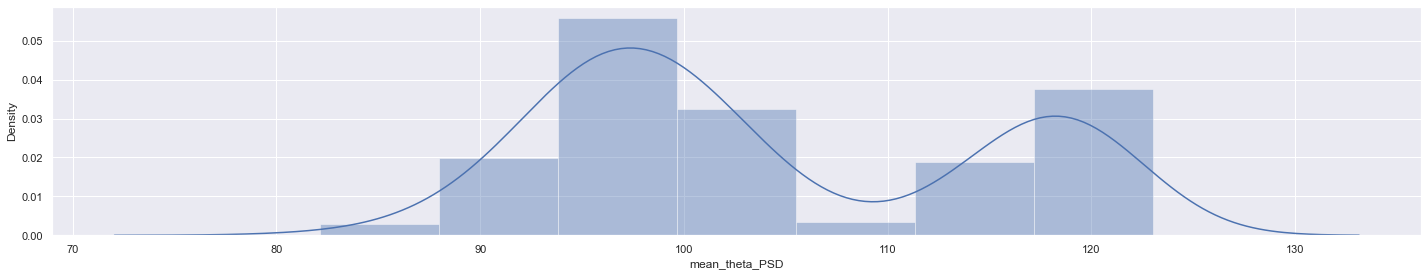

In [ ]:
import seaborn as sns; sns.set()
sns.distplot(data.mean_theta_PSD)
plt.show()

In [ ]:
help(smf.mixedlm)

Help on method from_formula in module statsmodels.regression.mixed_linear_model:

from_formula(formula, data, re_formula=None, vc_formula=None, subset=None, use_sparse=False, missing='none', *args, **kwargs) method of builtins.type instance
    Create a Model from a formula and dataframe.
    
    Parameters
    ----------
    formula : str or generic Formula object
        The formula specifying the model
    data : array_like
        The data for the model. See Notes.
    re_formula : str
        A one-sided formula defining the variance structure of the
        model.  The default gives a random intercept for each
        group.
    vc_formula : dict-like
        Formulas describing variance components.  `vc_formula[vc]` is
        the formula for the component with variance parameter named
        `vc`.  The formula is processed into a matrix, and the columns
        of this matrix are linearly combined with independent random
        coefficients having mean zero and a common vari

In [ ]:
def produce_df(rows, columns, row_names=None, column_names=None):
    """rows is a list of lists that will be used to build a MultiIndex
    columns is a list of lists that will be used to build a MultiIndex"""
    row_index = pd.MultiIndex.from_product(rows, names=row_names)
    col_index = pd.MultiIndex.from_product(columns, names=column_names)
    return pd.DataFrame(index=row_index, columns=col_index)
dat1 = alldat[1][1]
print(dat1.keys())

dict_keys(['V', 't_off', 'locs', 'srate', 'scale_uv', 't_on', 'target', 'stim_id', 'response', 'rt', 'expinfo', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [ ]:
print(len(dat1['target']))

100


In [ ]:
### IGNORE EVERYTHING BELOW THIS ###

In [ ]:
### FOR LOOKING AT ALL CHANNELS ###

# divide into trials and average
nt, nchan = V_filt.shape
nstim = len(dat_filt['t_on'])

# use a timerange from 400ms before to 1600ms after the stimulus onset
trange = np.arange(-500, 1000)
ts = dat_filt['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V_filt[ts, :], (nstim, 1500, nchan))

V_resp = (V_epochs[dat_filt['response'] == 1]).mean(0)
V_base = (V_epochs[dat_filt['response'] == 0]).mean(0)



In [ ]:
# if you just want to look at one channel at a time
V_channel = V_epochs[:,:,0]
print(V_epochs.shape)

(100, 1500, 64)


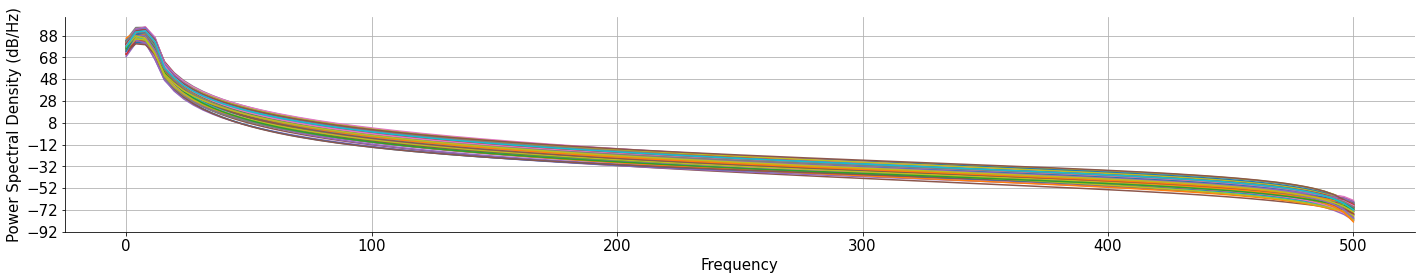

In [ ]:
# again, just plotting PSD for one channel at a time
V_channel = V_epochs[:,:,3]

plt.figure()
for j in range(len(V_channel)):
    psd_chan = plt.psd(V_channel[j,:],Fs=1000)
plt.show()

In [ ]:
#chen made this function 
def Average(lst):
    return sum(lst) / len(lst)

(0.0, 20.0)

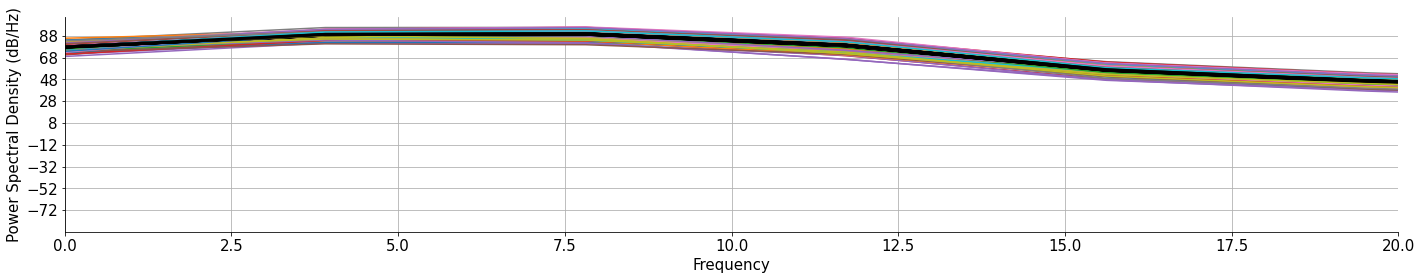

In [ ]:
#this is to plot all PSDs for one channel
psd0_list=[]
freq0_list=[]
for j in range(100):
    Pxx, freqs=plt.psd(V_channel[j,:],Fs=1000)
    #plt.plot(psd[1],psd[0])
    Pxx=10*np.log10(Pxx)
    psd0_list.append(Pxx)
    freq0_list.append(freqs)
    temp_ave_psd[j] = (Average(psd0_list))   
    plt.plot(freq0_list[-1], Average(psd0_list),color='k',lw=3)
ave_psd = np.mean(temp_ave_psd,axis=0)
plt.xlim([0, 20])
#plt.ylim([0,100])


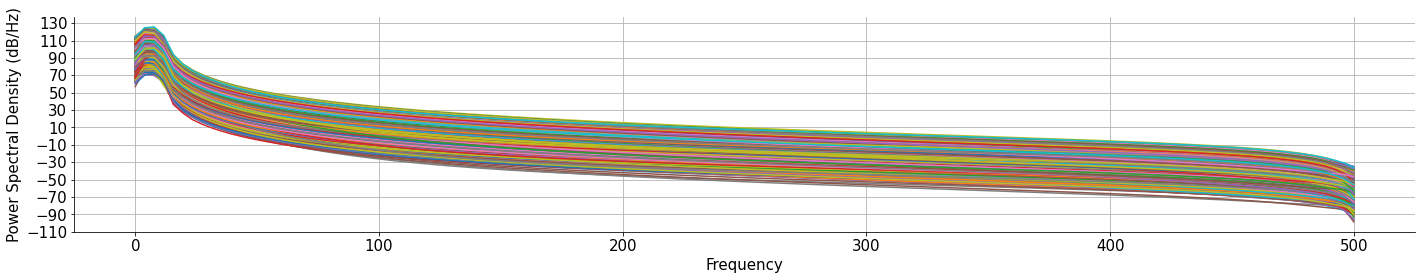

In [ ]:
# this is to create and plot all PSDs from each trial in each channel
# WARNING: this takes a long time to run

#initialize temp matrix to store the PSDs for each t_on
temp_ave_psd=np.zeros((100,129))

temp_ave_chan = np.zeros((60,129,100))
for i in range(60):
    psd0_list=[]
    freq0_list=[]
    for j in range(100):
        Pxx, freqs=plt.psd(V_epochs[j,:,i],Fs=1000)
        #plt.plot(psd[1],psd[0])
        Pxx=10*np.log10(Pxx)
        psd0_list.append(Pxx)
        freq0_list.append(freqs)
        #temp_ave_psd[j]
        temp_ave_psd[j] = (Average(psd0_list))   
        #plt.plot(freq0_list[-1], Average(psd0_list),color='k',lw=3)
    ave_psd = np.mean(temp_ave_psd,axis=0)
    
    #this matrix has the average PSD from each channel, averaged across trials
    temp_ave_chan[i] = ave_psd



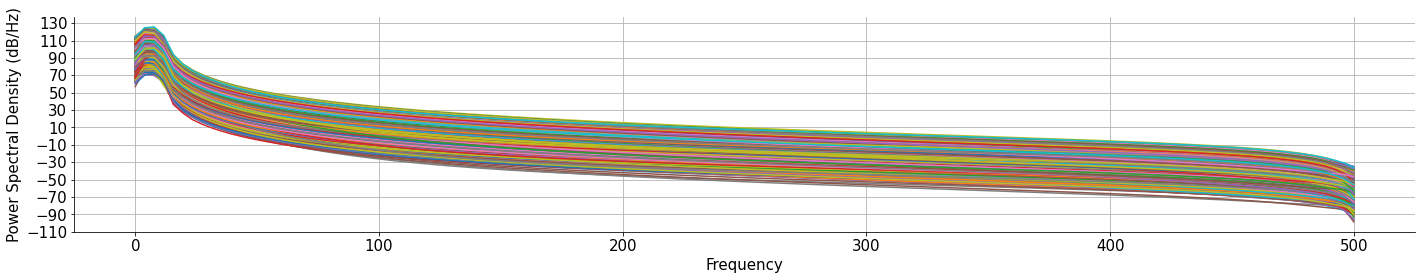

In [ ]:
# this is to create and plot all PSDs from each trial in each channel
# WARNING: this takes a long time to run

#initialize temp matrix to store the PSDs for each t_on
temp_ave_psd=np.zeros((60,100,129))

temp_ave_chan = np.zeros((60,100,129))
for i in range(60):
    psd0_list= np.zeros((100,129))
    freq0_list= np.zeros((100,129))
    for j in range(100):
        Pxx, freqs=plt.psd(V_epochs[j,:,i],Fs=1000)
        #plt.plot(psd[1],psd[0])
        Pxx=10*np.log10(Pxx)
        #psd0_list[j] = Pxx
        temp_ave_chan[i][j] = Pxx  
        freq0_list[j] = freqs


129


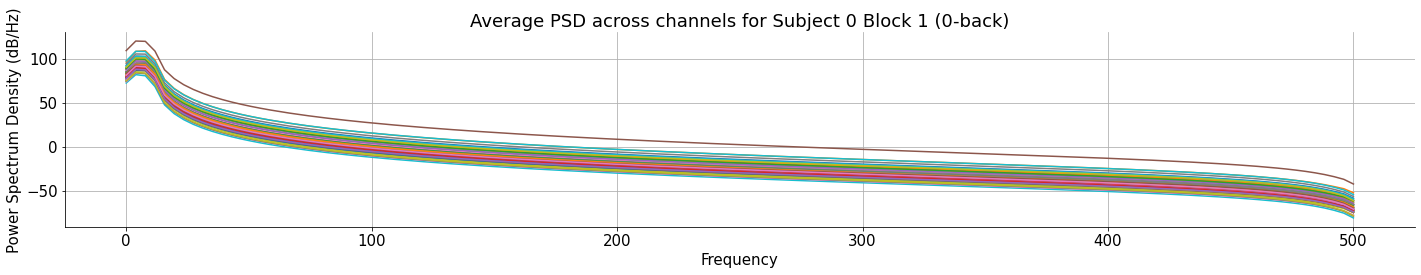

In [ ]:
#plotting just the average PSD for each channel
plt.plot(freqs,temp_ave_chan.T);
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum Density (dB/Hz)');
plt.grid()
plt.title('Average PSD across channels for Subject 0 Block 1 (0-back)');

In [ ]:
#ave_psd_11 = temp_ave_chan.T
print(ave_psd_11.shape)

(129, 60)


In [ ]:
#ave_psd_11 = ave_psd_11.T
print(ave_psd_11.shape)

(60, 129)


In [ ]:
print(freqs)

[  0.        3.90625   7.8125   11.71875  15.625    19.53125  23.4375
  27.34375  31.25     35.15625  39.0625   42.96875  46.875    50.78125
  54.6875   58.59375  62.5      66.40625  70.3125   74.21875  78.125
  82.03125  85.9375   89.84375  93.75     97.65625 101.5625  105.46875
 109.375   113.28125 117.1875  121.09375 125.      128.90625 132.8125
 136.71875 140.625   144.53125 148.4375  152.34375 156.25    160.15625
 164.0625  167.96875 171.875   175.78125 179.6875  183.59375 187.5
 191.40625 195.3125  199.21875 203.125   207.03125 210.9375  214.84375
 218.75    222.65625 226.5625  230.46875 234.375   238.28125 242.1875
 246.09375 250.      253.90625 257.8125  261.71875 265.625   269.53125
 273.4375  277.34375 281.25    285.15625 289.0625  292.96875 296.875
 300.78125 304.6875  308.59375 312.5     316.40625 320.3125  324.21875
 328.125   332.03125 335.9375  339.84375 343.75    347.65625 351.5625
 355.46875 359.375   363.28125 367.1875  371.09375 375.      378.90625
 382.8125  386.718

In [ ]:
psd_for_lme = np.zeros((60))
#print(psd_for_lme)
print((ave_psd_11[2,1:3]))
print(len(ave_psd_11))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[90.50616006 91.31942981]
60


In [ ]:
for i in range (len(ave_psd_11)):
    psd_for_lme[i] = np.mean(ave_psd_11[i,1:3])
print(psd_for_lme)
    

[100.9426063  108.83342446  90.91279494  89.35672352  91.11204327
  86.99860601  93.34807904  95.95064966  92.50553193 101.74535653
  87.50009988  88.38398583  88.44950012  87.49355314  93.7982082
 120.10906454  90.71242778  87.94664714  86.32975262  81.48497411
  86.9604222   88.94196662  99.15499601  89.62384418  90.62063134
  96.01114817  83.9872783   83.71983544  84.35136684  88.25220665
  99.88735221  99.09881266  95.85974204  88.8651323   90.26177889
  87.62424501  96.31882587  94.82515501  88.7197252   91.27396649
 103.05591193 100.43141514  94.43695711  90.5782744   97.48610284
  91.8433352   89.2651484   95.17991215  92.39820232 102.58327822
  88.89209316  93.53657417  99.73313389  89.4648031   87.93258536
  92.2523721   91.52455969 105.51948762 101.0645752  108.50653332]


In [ ]:
print(ave_psd)

[ 97.70128911 108.6125658  108.40050083  97.14174597  75.89365661
  65.99796041  59.07963991  53.72400737  49.32498917  45.59918177
  42.36237225  39.50057815  36.93634191  34.61184086  32.48583528
  30.52679481  28.71000743  27.01588893  25.42863675  23.93550268
  22.52561526  21.19009607  19.92132327  18.71287041  17.55905062
  16.45509513  15.39674752  14.38027861  13.40240098  12.46020763
  11.55106806  10.672659     9.82286911   8.99979522   8.20171163
   7.42704906   6.67437061   5.94236667   5.22982796   4.53565007
   3.8588046    3.19834788   2.55340044   1.92314663   1.30682764
   0.70373489   0.11320544  -0.46538059  -1.03260557  -1.58901703
  -2.13513017  -2.6714321   -3.19838219  -3.71641637  -4.22594785
  -4.72736946  -5.22105514  -5.7073619   -6.1866307   -6.65918826
  -7.12534786  -7.58541086  -8.03966751  -8.488398    -8.93187344
  -9.37035673  -9.80410335 -10.23336224 -10.65837648 -11.07938418
 -11.496619   -11.91031107 -12.32068757 -12.72797346 -13.13239221
 -13.53416

In [ ]:
help(plt.psd)

Help on function psd in module matplotlib.pyplot:

psd(x, NFFT=None, Fs=None, Fc=None, detrend=None, window=None, noverlap=None, pad_to=None, sides=None, scale_by_freq=None, return_line=None, *, data=None, **kwargs)
    Plot the power spectral density.
    
    The power spectral density :math:`P_{xx}` by Welch's average
    periodogram method.  The vector *x* is divided into *NFFT* length
    segments.  Each segment is detrended by function *detrend* and
    windowed by function *window*.  *noverlap* gives the length of
    the overlap between segments.  The :math:`|\mathrm{fft}(i)|^2`
    of each segment :math:`i` are averaged to compute :math:`P_{xx}`,
    with a scaling to correct for power loss due to windowing.
    
    If len(*x*) < *NFFT*, it will be zero padded to *NFFT*.
    
    Parameters
    ----------
    x : 1-D array or sequence
        Array or sequence containing the data
    
    Fs : float, default: 2
        The sampling frequency (samples per time unit).  It is us

In [ ]:
### random code down here pls ignore###

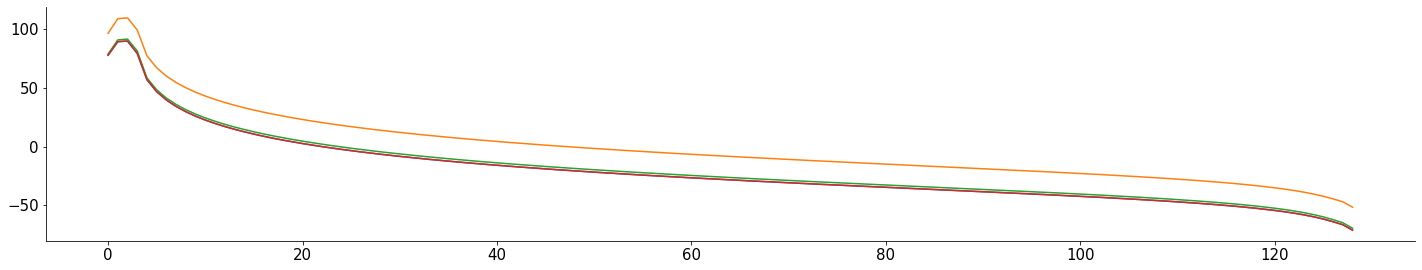

In [ ]:
plt.figure()
for j in range(len(ave_psd)):
    plt.plot(ave_psd[j])
plt.show()

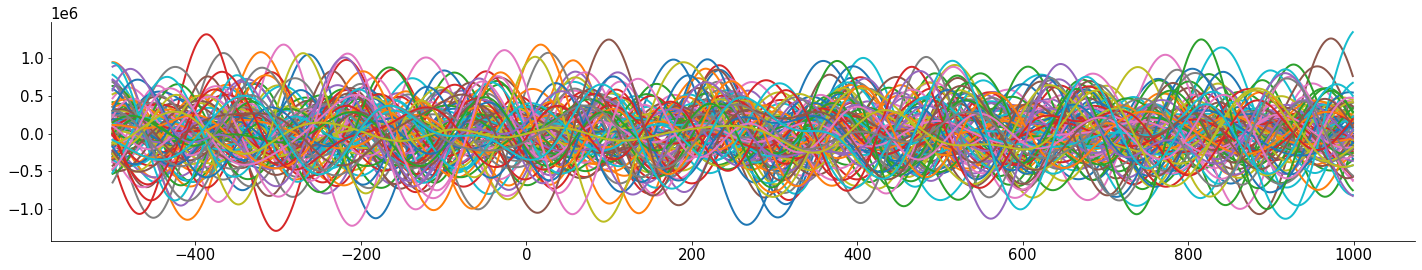

In [ ]:
plt.figure()
for j in range(len(V_channel)):
    plt.plot(trange, V_channel[j,:], lw=2)
plt.show()

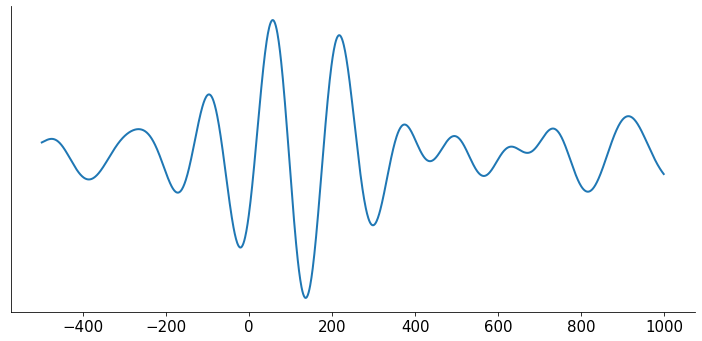

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(trange, V_channel[1,:], lw=2)
#plt.plot(trange, V_base, lw=2)
#plt.title('ch%d'%j)
plt.yticks([])
#plt.ylim([0, 3])
plt.show()